<a href="https://colab.research.google.com/github/Geoffysicist/skewt/blob/refactor/f160.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# f160.ipynb
Create an F160 (skewT - logP) diagram from [BUFR 309052](https://vocabulary-manager.eumetsat.int/vocabularies/BUFR/WMO/32/TABLE_D/309052) sounding data.

In [142]:
!pip install -q pybufrkit
!pip install -q metpy

import pandas as pd
import numpy as np
from pandas.core.frame import DataFrame
from ipywidgets import FileUpload
from IPython.display import display
from traitlets.traitlets import Dict

from pybufrkit.decoder import Decoder
from pybufrkit.dataquery import NodePathParser, DataQuerent
from pybufrkit.bufr import BufrMessage
from pybufrkit.renderer import FlatJsonRenderer

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units, pandas_dataframe_to_unit_arrays

BUFR_CODES_303054 = {
  'time_offset': '004086', # Long time period or displacement (s)
  'pressure': '007004', # Pressure (Pa)
  'gph': '010009', # Geopotential height (m)
  'lat_offset': '005015', # Latitude displacement (high accuracy) (deg)
  'long_offset': '006015', # Longitude displacement (high accuracy) (deg)
  'temp': '012101', # Temperature/air temperature (K)
  'dewpoint': '012103', # Dewpoint temperature (K)
  'wind_dir': '011001', # Wind direction (degree true)
  'wind_speed': '011002', # Wind speed (m/s)
}

UNITS = {
  'time_offset': units.second, # Long time period or displacement (s)
  'pressure': units.pascal, # Pressure (Pa)
  'gph': units.metre, # Geopotential height (m)
  'lat_offset': units.degree_E, # Latitude displacement (high accuracy) (deg)
  'long_offset': units.degree_N, # Longitude displacement (high accuracy) (deg)
  'temp': units.kelvin, # Temperature/air temperature (K)
  'dewpoint': units.kelvin, # Dewpoint temperature (K)
  'wind_dir': units.degree_E, # Wind direction (degree true)
  'wind_speed': units.meter / units.second, # Wind speed (m/s)  
}


In [153]:
def decode_BUFR(file_upload: FileUpload) -> BufrMessage:
  """Decodes the raw BUFR file."""
  for uploaded_filename in file_upload.value:
      data_stream = file_upload.value[uploaded_filename]['content'] 
  return Decoder().process(data_stream)

def query_BUFR(message: BufrMessage) -> DataFrame:
  """ Reads data from BUFR message into a dataframe."""

  readings = {}
  for key, code in BUFR_CODES_303054.items():
    data = DataQuerent(NodePathParser()).query(message, f'303054/{code}')
    readings[key] = FlatJsonRenderer().render(data)[0]

  readings_df = pd.DataFrame.from_dict(readings)
  # clean the data
  readings_df = readings_df.dropna() # remove rows with missing data
  readings_df = readings_df.drop_duplicates(subset="pressure") # need monotonically increasing pressure
  return readings_df

def barbs_get(readings: dict, diff: int=2000) -> tuple:
  p_barbs = [] * units.pascal
  u_barbs = [] * units.meter / units.second
  v_barbs = [] * units.meter / units.second
  p_last = 999999 * units.pascal
  diff = diff * units.pascal
  u, v = mpcalc.wind_components(readings['wind_speed'], readings['wind_dir'])
  for i, p in enumerate(readings['pressure']):
    if (p_last - p) >= diff:
      p_barbs = np.append(p_barbs, p)
      u_barbs = np.append(u_barbs, u[i])
      v_barbs = np.append(v_barbs, v[i])
      p_last = p
  return p_barbs, u_barbs, v_barbs

In [19]:
uploads = FileUpload(accept='.bfr', multiple=True)
display(uploads)

FileUpload(value={}, accept='.bfr', description='Upload', multiple=True)

In [193]:
bufr_message = decode_BUFR(uploads)
readings_df = query_BUFR(bufr_message)
readings = pandas_dataframe_to_unit_arrays(readings_df, UNITS)
T_0 = readings['temp'][0]
Td_0 = readings['dewpoint'][0]
lcl_pressure, lcl_temperature = mpcalc.lcl(readings['pressure'][0],T_0, Td_0)
parcel_prof = mpcalc.parcel_profile(readings['pressure'], T_0, Td_0).to('degC')
u, v = mpcalc.wind_components(readings['wind_speed'], readings['wind_dir'])

# # Create a new figure. The dimensions here give a good aspect ratio
# fig = plt.figure(figsize=(12, 12))
# # fig, ax1 = plt.subplots(figsize=(12, 12))
# skew = SkewT(fig, rotation=30, aspect=120)

# # Plot the data using normal plotting functions, in this case using
# # log scaling in Y, as dictated by the typical meteorological plot
# skew.plot(readings['pressure'], readings['temp'], 'r')
# skew.plot(readings['pressure'], readings['dewpoint'], 'g')
# # skew.plot_barbs(readings['pressure'], u, v)
# skew.plot_barbs(*barbs_get(readings))
# skew.ax.set_ylim(1000, 100)
# skew.ax.set_xlim(-40, 60)

# # Plot LCL temperature as black dot
# skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# # Plot the parcel profile as a black line
# skew.plot(readings['pressure'], parcel_prof, 'k', linewidth=2)

# # Shade areas of CAPE and CIN
# skew.shade_cin(readings['pressure'], readings['temp'], parcel_prof, readings['dewpoint'])
# skew.shade_cape(readings['pressure'], readings['temp'], parcel_prof)

# # Plot a zero degree isotherm
# skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# # Add the relevant special lines
# skew.plot_dry_adiabats()
# skew.plot_moist_adiabats()
# skew.plot_mixing_lines()

# plt.show()

In [281]:
from ipywidgets import FloatSlider
from IPython.display import display
T_0 = np.float64(readings['temp'][0].to('degC'))
t_0_slider = FloatSlider(value=T_0, min=-10, max=50)

def t_slider_change(val):
  Temp_0 = val
  print(f"{Temp_0.new} {T_0}")

t_0_slider.observe(t_slider_change, names='value')

display(t_0_slider)

FloatSlider(value=24.390000000000043, max=50.0, min=-10.0)

24.2 24.390000000000043
29.3 24.390000000000043
29.0 24.390000000000043
35.3 24.390000000000043


In [273]:

import matplotlib.animation as animation
# from matplotlib.widgets import Slider, Button
# from ipywidgets import FloatSlider, AppLayout
from IPython import display

parcel_prof = mpcalc.parcel_profile(readings['pressure'], T_0, Td_0).to('degC')
# T_initial = np.float64(readings['temp'][0].to('degC'))

# def update_parcel_profile(T: float):
#   T = T *units.degC
#   parcel_prof = mpcalc.parcel_profile(readings['pressure'], T, Td_0).to('degC')
#   parcel_plot.set_xdata(parcel_prof)
#   # plt.draw()
#   print(type(parcel_plot))
#   # skew.draw()
#   # skew.canvas.flush_events()
#   # fig.canvas.draw_idle()
#   # display.clear_output(wait=True)
#   # display.display(plt.gcf())

# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(12, 12))
# fig, ax = plt.subplots(figsize=(12, 12))
skew = SkewT(fig, rotation=30, aspect=120)


# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(readings['pressure'], readings['temp'], 'r')
skew.plot(readings['pressure'], readings['dewpoint'], 'g')
# skew.plot_barbs(readings['pressure'], u, v)
skew.plot_barbs(*barbs_get(readings))
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Plot LCL temperature as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
parcel_plot, = skew.plot(readings['pressure'], parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(readings['pressure'], readings['temp'], parcel_prof, readings['dewpoint'])
skew.shade_cape(readings['pressure'], readings['temp'], parcel_prof)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

display.display(plt.show())

# def update(Surface_temp = 25.0):
#   update_parcel_profile(Surface_temp)
#   print(Surface_temp)
  

# interact(update, w=(-10, 50, 0.1));

ValueError: ignored

In [ ]:
!pip install ipympl
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

interactive(children=(FloatSlider(value=4.0, description='w', max=10.0, min=-10.0), Output()), _dom_classes=('…

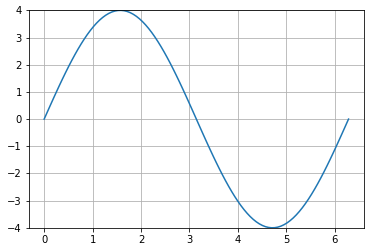

In [237]:
# set up plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_ylim([-4, 4])
ax.grid(True)
 
# generate x values
x = np.linspace(0, 2 * np.pi, 100)
 
from ipywidgets import interact

def my_sine(x, w):
    """
    Return a sine for x with angular frequeny w and amplitude amp.
    """
    return w*np.sin(x)
 
 
# @widgets.interact(w=(0, 10, 1), amp=(0, 4, .1), phi=(0, 2*np.pi+0.01, 0.01))
amp=(0, 4, .1)
phi=(0, 2*np.pi+0.01, 0.01)

def update(w = 4.0):
  """Remove old lines from plot and plot new one"""
  [l.remove() for l in ax.lines]
  ax.plot(x, my_sine(x, w), color='C0')
  plt.show()

interact(update, w=(-10, 10, 0.1));